# GRU Weather Prediction - Binary Classification (RainToday)

### Imports and CUDA

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import os
from sklearn.metrics import roc_auc_score

In [4]:
# Use GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Load Data Paths

In [16]:
TRAIN_PATH = "C:/Users/longr/Desktop/theory-and-practice-of-deep-learning-project/data/processed-data/train.csv"
TEST_PATH = "C:/Users/longr/Desktop/theory-and-practice-of-deep-learning-project/data/processed-data/test.csv"
SAVE_DIR = "saved_models"
os.makedirs(SAVE_DIR, exist_ok=True)

# Configuration

In [17]:
SEQ_LENGTHS = [3, 5, 7]
BATCH_SIZE = 64
EPOCHS = 50
LEARNING_RATE = 5e-4
#LEARNING_RATE = 1e-3
VALIDATION_SPLIT = 0.2
PATIENCE = 5

# Custom Dataset 

In [18]:
class RainDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = torch.tensor(sequences, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

# Sequence Generator 

In [19]:
def create_sequences(data, seq_len, feature_cols, target_col):
    sequences, labels = [], []
    for loc in data['Location'].unique():
        loc_data = data[data['Location'] == loc].sort_values('Date')
        X = loc_data[feature_cols].values
        y = loc_data[target_col].values
        for i in range(len(X) - seq_len):
            sequences.append(X[i:i+seq_len])
            labels.append(y[i+seq_len])
    return np.array(sequences), np.array(labels)

# GRU Model 

In [20]:
class RainGRU(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super().__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.dropout(out[:, -1, :])
        return self.fc(out)  # return raw logits


# GRU + Transformer hybrid model

In [21]:
class RainGRUTransformer(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_heads=4, num_layers=1):
        super().__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_size, nhead=num_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        gru_out, _ = self.gru(x)  # (B, T, H)
        trans_out = self.transformer(gru_out)  # (B, T, H)
        pooled = trans_out[:, -1, :]  # last time step
        out = self.dropout(pooled)
        return self.fc(out)

# Training Function

In [22]:
def train(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for xb, yb in loader:
        optimizer.zero_grad()
        preds = model(xb).squeeze()
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# Evaluation Function 

In [32]:
def evaluate(model, loader):
    model.eval()
    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for xb, yb in loader:
            logits = model(xb).squeeze()
            probs = torch.sigmoid(logits)
            preds = probs > 0.5
            y_true.extend(yb.tolist())
            y_pred.extend(preds.int().tolist())
            y_prob.extend(probs.tolist())
    print(classification_report(y_true, y_pred))
    print(confusion_matrix(y_true, y_pred))
    print("AUC-ROC:", roc_auc_score(y_true, y_prob))

    # Plot predictions
    plt.figure(figsize=(12, 4))
    plt.scatter(range(100), y_true[:100], label='Actual', color='blue', marker='o')
    plt.scatter(range(100), y_pred[:100], label='Predicted (0 or 1)', color='red', marker='x')
    plt.title("RainToday: Actual vs Predicted (First 100 Samples)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Run For Different Sequence Lengths


=== Training with sequence length 3 ===
Epoch 1/50 - Loss: 0.8883 - Val Loss: 0.8469
Saved new best model.
Epoch 2/50 - Loss: 0.8529 - Val Loss: 0.8498
Epoch 3/50 - Loss: 0.8443 - Val Loss: 0.8318
Saved new best model.
Epoch 4/50 - Loss: 0.8401 - Val Loss: 0.8293
Saved new best model.
Epoch 5/50 - Loss: 0.8343 - Val Loss: 0.8341
Epoch 6/50 - Loss: 0.8304 - Val Loss: 0.8207
Saved new best model.
Epoch 7/50 - Loss: 0.8275 - Val Loss: 0.8166
Saved new best model.
Epoch 8/50 - Loss: 0.8214 - Val Loss: 0.8248
Epoch 9/50 - Loss: 0.8190 - Val Loss: 0.8119
Saved new best model.
Epoch 10/50 - Loss: 0.8141 - Val Loss: 0.8123
Epoch 11/50 - Loss: 0.8125 - Val Loss: 0.8183
Epoch 12/50 - Loss: 0.8088 - Val Loss: 0.8171
Epoch 13/50 - Loss: 0.8049 - Val Loss: 0.8138
Epoch 14/50 - Loss: 0.8014 - Val Loss: 0.8082
Saved new best model.
Epoch 15/50 - Loss: 0.7963 - Val Loss: 0.8070
Saved new best model.
Epoch 16/50 - Loss: 0.7923 - Val Loss: 0.8122
Epoch 17/50 - Loss: 0.7883 - Val Loss: 0.8270
Epoch 18/5

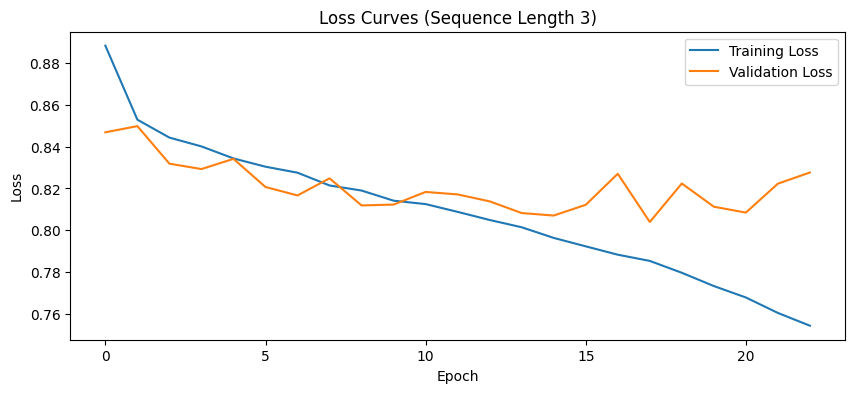


--- Validation Set Evaluation ---


C:\Users\longr\AppData\Local\Temp\ipykernel_1684\1861124988.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


              precision    recall  f1-score   support

         0.0       0.91      0.76      0.83     15328
         1.0       0.47      0.73      0.57      4350

    accuracy                           0.76     19678
   macro avg       0.69      0.75      0.70     19678
weighted avg       0.81      0.76      0.77     19678

[[11699  3629]
 [ 1166  3184]]


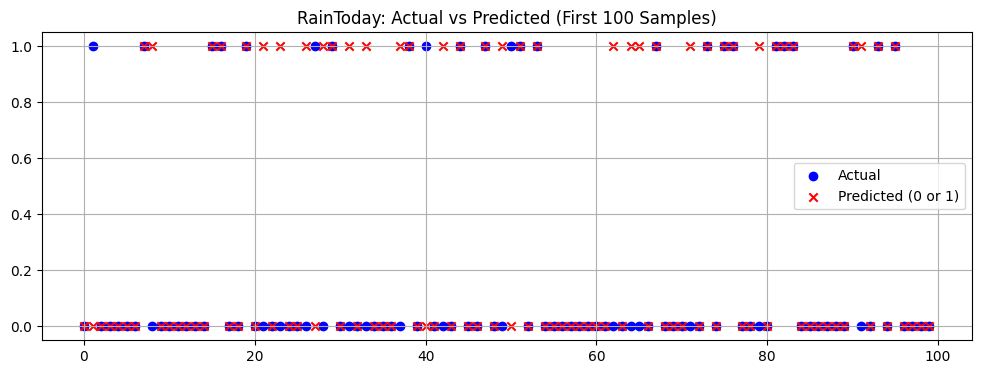


--- Test Set Evaluation ---
              precision    recall  f1-score   support

         0.0       0.86      0.72      0.78     32735
         1.0       0.37      0.59      0.46      9368

    accuracy                           0.69     42103
   macro avg       0.62      0.65      0.62     42103
weighted avg       0.75      0.69      0.71     42103

[[23431  9304]
 [ 3819  5549]]


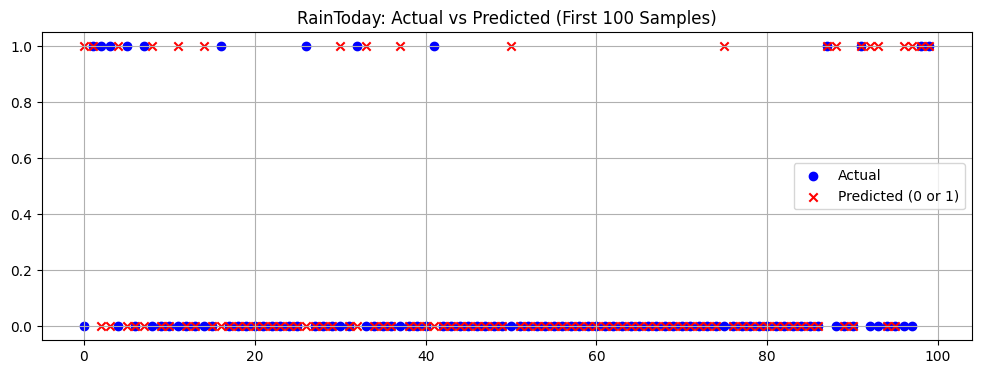


=== Training with sequence length 5 ===
Epoch 1/50 - Loss: 0.8854 - Val Loss: 0.8550
Saved new best model.
Epoch 2/50 - Loss: 0.8477 - Val Loss: 0.8737
Epoch 3/50 - Loss: 0.8373 - Val Loss: 0.8537
Saved new best model.
Epoch 4/50 - Loss: 0.8316 - Val Loss: 0.8409
Saved new best model.
Epoch 5/50 - Loss: 0.8243 - Val Loss: 0.8413
Epoch 6/50 - Loss: 0.8214 - Val Loss: 0.8607
Epoch 7/50 - Loss: 0.8182 - Val Loss: 0.8401
Saved new best model.
Epoch 8/50 - Loss: 0.8128 - Val Loss: 0.8307
Saved new best model.
Epoch 9/50 - Loss: 0.8093 - Val Loss: 0.8349
Epoch 10/50 - Loss: 0.8051 - Val Loss: 0.8477
Epoch 11/50 - Loss: 0.8005 - Val Loss: 0.8245
Saved new best model.
Epoch 12/50 - Loss: 0.7964 - Val Loss: 0.8427
Epoch 13/50 - Loss: 0.7930 - Val Loss: 0.8361
Epoch 14/50 - Loss: 0.7875 - Val Loss: 0.8343
Epoch 15/50 - Loss: 0.7825 - Val Loss: 0.8309
Epoch 16/50 - Loss: 0.7782 - Val Loss: 0.8233
Saved new best model.
Epoch 17/50 - Loss: 0.7729 - Val Loss: 0.8304
Epoch 18/50 - Loss: 0.7658 - Val

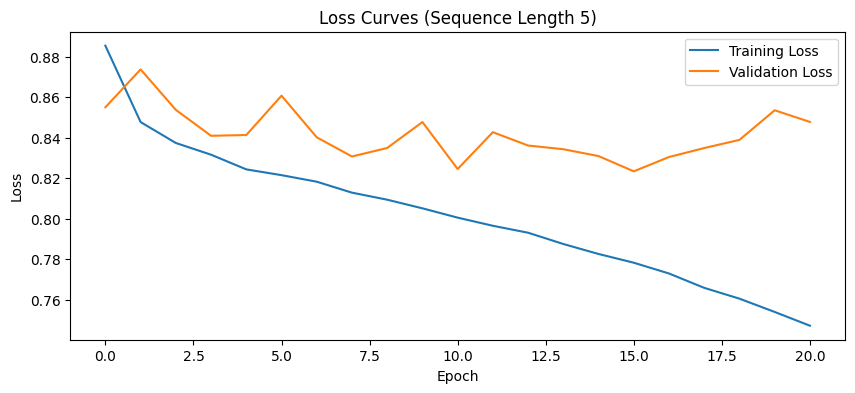


--- Validation Set Evaluation ---


C:\Users\longr\AppData\Local\Temp\ipykernel_1684\1861124988.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


              precision    recall  f1-score   support

         0.0       0.90      0.77      0.83     15186
         1.0       0.47      0.71      0.56      4472

    accuracy                           0.75     19658
   macro avg       0.68      0.74      0.70     19658
weighted avg       0.80      0.75      0.77     19658

[[11626  3560]
 [ 1310  3162]]


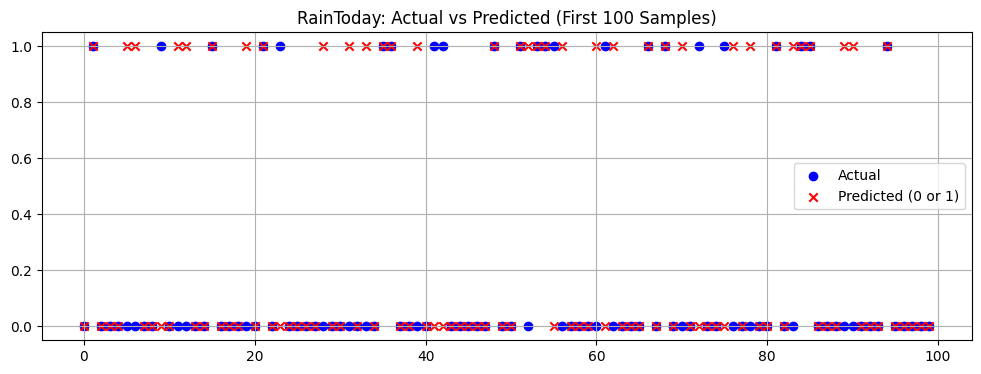


--- Test Set Evaluation ---
              precision    recall  f1-score   support

         0.0       0.86      0.73      0.79     32656
         1.0       0.38      0.59      0.46      9349

    accuracy                           0.70     42005
   macro avg       0.62      0.66      0.63     42005
weighted avg       0.75      0.70      0.72     42005

[[23802  8854]
 [ 3852  5497]]


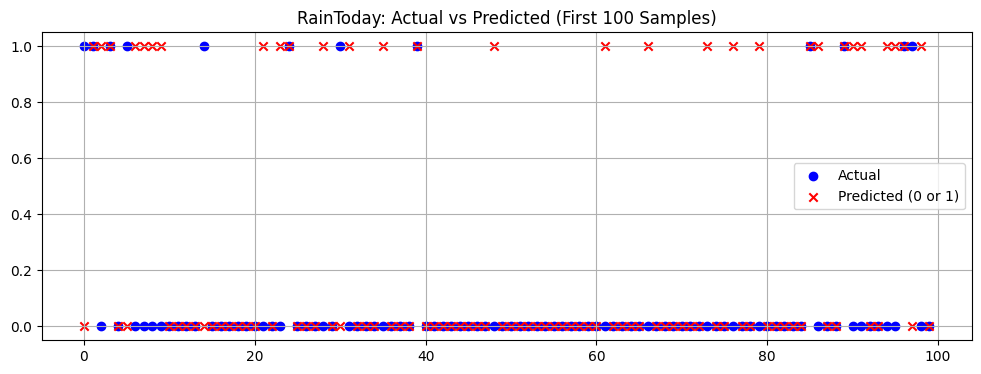


=== Training with sequence length 7 ===
Epoch 1/50 - Loss: 0.8869 - Val Loss: 0.8666
Saved new best model.
Epoch 2/50 - Loss: 0.8447 - Val Loss: 0.8480
Saved new best model.
Epoch 3/50 - Loss: 0.8367 - Val Loss: 0.8347
Saved new best model.
Epoch 4/50 - Loss: 0.8304 - Val Loss: 0.8417
Epoch 5/50 - Loss: 0.8237 - Val Loss: 0.8260
Saved new best model.
Epoch 6/50 - Loss: 0.8199 - Val Loss: 0.8352
Epoch 7/50 - Loss: 0.8151 - Val Loss: 0.8339
Epoch 8/50 - Loss: 0.8087 - Val Loss: 0.8354
Epoch 9/50 - Loss: 0.8051 - Val Loss: 0.8362
Epoch 10/50 - Loss: 0.8009 - Val Loss: 0.8360
Early stopping triggered.


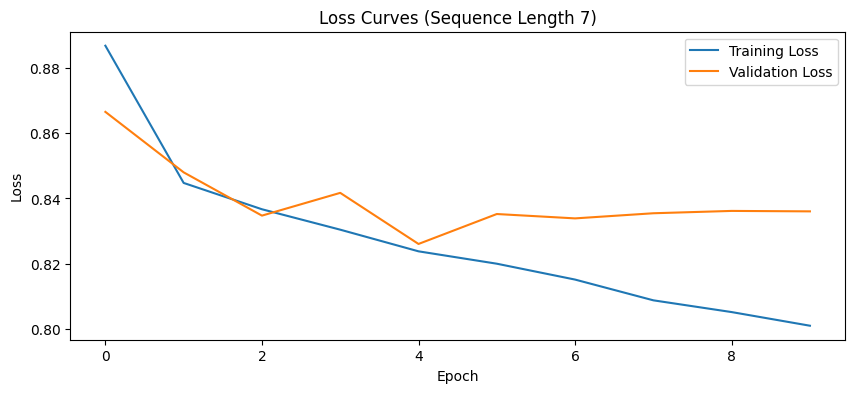


--- Validation Set Evaluation ---


C:\Users\longr\AppData\Local\Temp\ipykernel_1684\1861124988.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


              precision    recall  f1-score   support

         0.0       0.90      0.78      0.83     15130
         1.0       0.48      0.70      0.57      4508

    accuracy                           0.76     19638
   macro avg       0.69      0.74      0.70     19638
weighted avg       0.80      0.76      0.77     19638

[[11754  3376]
 [ 1338  3170]]


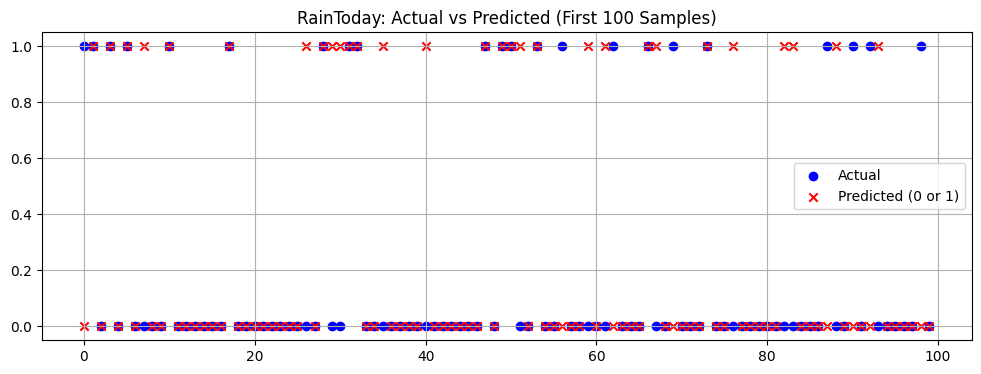


--- Test Set Evaluation ---
              precision    recall  f1-score   support

         0.0       0.85      0.75      0.80     32572
         1.0       0.39      0.55      0.46      9335

    accuracy                           0.71     41907
   macro avg       0.62      0.65      0.63     41907
weighted avg       0.75      0.71      0.73     41907

[[24591  7981]
 [ 4178  5157]]


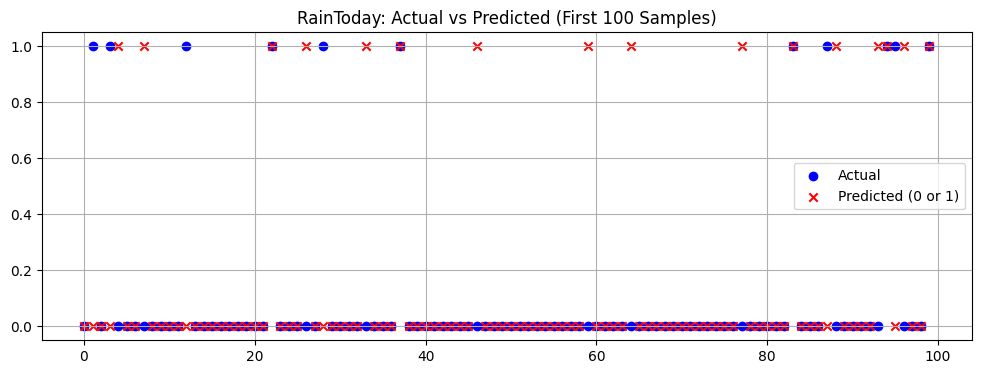

In [31]:
if __name__ == "__main__":
    train_df = pd.read_csv(TRAIN_PATH)
    test_df = pd.read_csv(TEST_PATH)

    TARGET_COL = "RainToday"
    FEATURE_COLS = train_df.columns.drop(TARGET_COL)

    scaler = MinMaxScaler()
    train_df[FEATURE_COLS] = scaler.fit_transform(train_df[FEATURE_COLS])
    test_df[FEATURE_COLS] = scaler.transform(test_df[FEATURE_COLS])

    # Compute class weights
    rain_count = train_df[TARGET_COL].sum()
    no_rain_count = len(train_df) - rain_count
    weight_ratio = no_rain_count / rain_count
    pos_weight = torch.tensor([weight_ratio], dtype=torch.float32)

    for seq_len in SEQ_LENGTHS:
        print(f"\n=== Training with sequence length {seq_len} ===")

        X_train, y_train = create_sequences(train_df, seq_len, FEATURE_COLS, TARGET_COL)
        X_test, y_test = create_sequences(test_df, seq_len, FEATURE_COLS, TARGET_COL)

        full_train_ds = RainDataset(X_train, y_train)
        val_size = int(len(full_train_ds) * VALIDATION_SPLIT)
        train_size = len(full_train_ds) - val_size
        train_ds, val_ds = random_split(full_train_ds, [train_size, val_size])

        test_ds = RainDataset(X_test, y_test)

        train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
        test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

        # model = RainGRU(input_size=X_train.shape[2])
        model = RainGRUTransformer(input_size=X_train.shape[2])

        optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)


        best_val_loss = float('inf')
        patience_counter = 0
        best_model_path = os.path.join(SAVE_DIR, f"gru_seq{seq_len}.pt")

        train_losses = []
        val_losses = []

        for epoch in range(EPOCHS):
            loss = train(model, train_loader, optimizer, criterion)
            train_losses.append(loss)
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for xb, yb in val_loader:
                    preds = model(xb).squeeze()
                    val_loss += criterion(preds, yb).item()
            val_loss /= len(val_loader)
            val_losses.append(val_loss)

            print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {loss:.4f} - Val Loss: {val_loss:.4f}")

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                torch.save(model.state_dict(), best_model_path)
                print("Saved new best model.")
            else:
                patience_counter += 1
                if patience_counter >= PATIENCE:
                    print("Early stopping triggered.")
                    break

        # Plot training and validation loss
        plt.figure(figsize=(10, 4))
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Loss Curves (Sequence Length {seq_len})')
        plt.legend()
        plt.show()
        
        # Load best model
        model.load_state_dict(torch.load(best_model_path))

        print("\n--- Validation Set Evaluation ---")
        evaluate(model, val_loader)

        print("\n--- Test Set Evaluation ---")
        evaluate(model, test_loader)